<a href="https://colab.research.google.com/github/leinaxd/Portfolio/blob/main/machine_learning/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DROPOUT
```
Author: Eichenbaum Daniel
Email: eichenbaum.daniel@gmail.com
```

This is a practical demo for understanding the theory behind: 
  ```
  Chapter: 7.12 Dropout

  Goodellow and Bengio, 
  Deep Learning, MIT Press, 2016
  http://www.deeplearningbook.org
  ```

UNSUPERVISED LEARNING
```
1 - Use the same img as Input and Output
2 - Then train a classifier using the intermediate representation
```

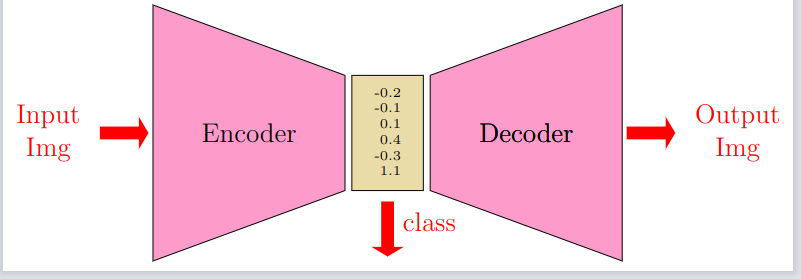

In [1]:
import torch, torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

DOWNLOAD CIFAR10 DATASET

In [2]:
#Download Dataset
BATCH_SIZE = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

CLASS_NAMES = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

100%|██████████| 170498071/170498071 [00:02<00:00, 72053433.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


VISUALIZATION

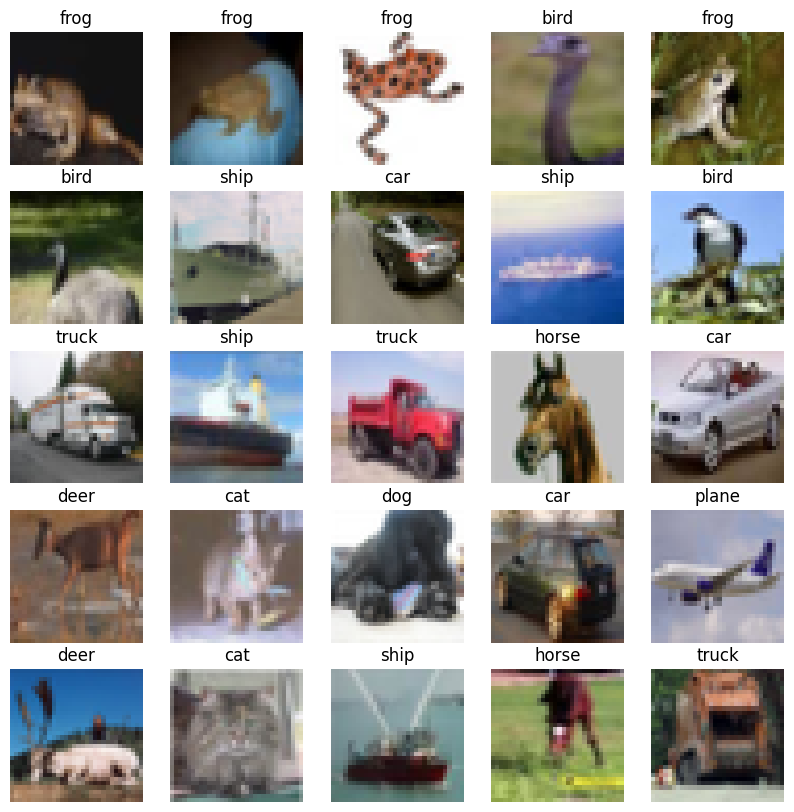

In [8]:
#Visualize Data
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        img = image_batch[n] / 2 + 0.5     # unnormalize
        img = img.numpy()
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title(CLASS_NAMES[label_batch[n]])
        plt.axis("off")
sample_images, sample_labels = next(iter(trainloader))
show_batch(sample_images, sample_labels)

MODEL

In [38]:
class EncoderNet(nn.Module):
    def __init__(self, input_shape=(3,32,32), pDropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
    
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        # self.sigma    = nn.ReLU(True)
        self.sigma    = nn.Tanh()
        self.dropout = nn.Dropout(pDropout)
        self.out_size = self._get_conv_output(input_shape)
        self.ff1 = nn.Linear(self.out_size, self.out_size)
    def _get_conv_output(self, shape):
        """Feedfoward para saber la dimensión de la convolucional"""
        batch_size = 1
        input = torch.rand(batch_size, *shape)
        output_conv = self.forward_conv(input)
        return output_conv.size(1)
        
    def forward_conv(self, x):
        x = self.pool(self.sigma(self.conv1(x))) #Conv1
        x = self.pool(self.sigma(self.conv2(x))) #Conv2
        x = self.pool(self.sigma(self.conv3(x))) #Conv3
        x = self.flatten(x)
        return x
    def forward(self, x):
        x = self.forward_conv(x)
        x = self.dropout(self.sigma(self.ff1(x)))
        return x

In [27]:
net_1 = EncoderNet()
n = net_1.out_size
print(n)

512


In [37]:
class DecoderNet(nn.Module):
    def __init__(self, input_shape=(128,2,2)):
        super().__init__()
        input_size = torch.prod(torch.tensor(input_shape))
        self.ff1  = nn.Linear(input_size, input_size)
        self.unflatten = nn.Unflatten(1, input_shape)
        self.conv1 = nn.ConvTranspose2d(128, 64, 11)
        self.conv2 = nn.ConvTranspose2d(64, 32, 11)
        self.conv3 = nn.ConvTranspose2d(32, 3, 11) #Output = (3,32,32)
        # self.sigma  = nn.ReLU(True)
        self.sigma  = nn.Tanh()
    def forward(self, x):
        x = self.sigma(self.ff1(x))
        x = self.unflatten(x)
        x = self.sigma(self.conv1(x))
        x = self.sigma(self.conv2(x))
        x = self.sigma(self.conv3(x)) # i Change this layer so it can output between [-1, 1]
        return x

In [ ]:
net_2  = DecoderNet(512)
z = torch.zeros((1,512))
net_2(z).shape

torch.Size([1, 128, 2, 2])
torch.Size([1, 64, 12, 12])
torch.Size([1, 32, 22, 22])
torch.Size([1, 3, 32, 32])


torch.Size([1, 3, 32, 32])

In [29]:
class ClassifierNet(nn.Module):
    def __init__(self, hidden_size, output_size, pDropout=0.25):
        super().__init__()
        self.ff1 = nn.Linear(hidden_size, 512)
        self.ff2 = nn.Linear(512, output_size)
        self.dropout = nn.Dropout(pDropout)

    def forward(self, x):
        x = self.dropout(F.relu(self.ff1(x))) #FF1
        x = self.ff2(x)                       #FF2
        return x

In [ ]:
net_3 = ClassifierNet(n, len(CLASS_NAMES))
net_3

TRAINING

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net_1      = EncoderNet().to(device)
net_2      = DecoderNet().to(device)
net_3      = ClassifierNet(net_1.out_size, len(CLASS_NAMES)).to(device)

criterion_1 = nn.MSELoss()
criterion_2 = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(net_1.parameters())
optimizer_2 = optim.Adam(net_2.parameters())
optimizer_3 = optim.Adam(net_3.parameters())

hist = {}
hist['train_loss'] = []
hist['train_acc'] = []
hist['test_loss'] = []
hist['test_acc'] = []

for epoch in range(50):
    net_1.train()
    net_2.train()
    net_3.train()
    train_loss = 0
    nSamples = 0
    train_correct = 0
    for batch_idx, (data, target) in enumerate(trainloader, start=0):
        #Unsupervised Feature Extraction 
        data = data.to(device)
        output_1 = net_1(data)
        output_2 = net_2(output_1)
        loss = criterion_1(output_2, data) #output = input
        train_loss += loss.item()
        nSamples += data.size(0)

        optimizer_1.zero_grad()
        optimizer_2.zero_grad()
        loss.backward()
        optimizer_1.step()
        optimizer_2.step()

        #Supervised Feature classification
        target   = target.to(device)
        output_3 = net_3(output_1.detach())
        loss_3   = criterion_2(output_3, target)

        optimizer_3.zero_grad()
        loss_3.backward()
        optimizer_3.step()
        
        scores, predictions = torch.max(output_3, 1)
        train_correct += int(sum(predictions == target))

    train_loss     = train_loss/nSamples
    train_accuracy = train_correct / nSamples
    hist['train_loss'].append(train_loss)
    hist['train_acc'].append(train_accuracy)
    print(f"{epoch}: train_Loss: {train_loss:.3}, Accuracy: {train_accuracy:.3}, ", end='')

    net_1.eval()
    net_3.eval()

    test_loss = 0
    nSamples = 0
    test_correct = 0

    example_images = []
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)          
            output_1 = net_1(data)
            output_3 = net_3(output_1)
            test_loss += criterion_2(output_3, target).item()
            
            scores, predictions = torch.max(output_3, 1)
            nSamples += target.size(0)
            test_correct += int(sum(predictions == target))

    test_accuracy = test_correct / nSamples
    test_loss = test_loss/nSamples

    hist['test_loss'].append(test_loss)
    hist['test_acc'].append(test_accuracy)
    print(f"test_loss: {test_loss:.3}, test_accuracy: {test_accuracy:.3}")

print("Finished Training")

cuda:0
0: train_Loss: 0.00233, Accuracy: 0.388, test_loss: 0.0485, test_accuracy: 0.447
1: train_Loss: 0.00187, Accuracy: 0.452, test_loss: 0.0461, test_accuracy: 0.477
2: train_Loss: 0.00177, Accuracy: 0.469, test_loss: 0.0451, test_accuracy: 0.487
3: train_Loss: 0.00171, Accuracy: 0.479, test_loss: 0.0442, test_accuracy: 0.503
4: train_Loss: 0.00167, Accuracy: 0.492, test_loss: 0.0433, test_accuracy: 0.512
5: train_Loss: 0.00164, Accuracy: 0.5, test_loss: 0.0428, test_accuracy: 0.521
6: train_Loss: 0.00161, Accuracy: 0.511, test_loss: 0.0425, test_accuracy: 0.518
7: train_Loss: 0.0016, Accuracy: 0.514, test_loss: 0.0423, test_accuracy: 0.519
8: train_Loss: 0.00158, Accuracy: 0.519, test_loss: 0.0417, test_accuracy: 0.526
9: train_Loss: 0.00156, Accuracy: 0.525, test_loss: 0.0415, test_accuracy: 0.535
10: train_Loss: 0.00155, Accuracy: 0.529, test_loss: 0.0413, test_accuracy: 0.536
11: train_Loss: 0.00154, Accuracy: 0.533, test_loss: 0.0411, test_accuracy: 0.538
12: train_Loss: 0.0015

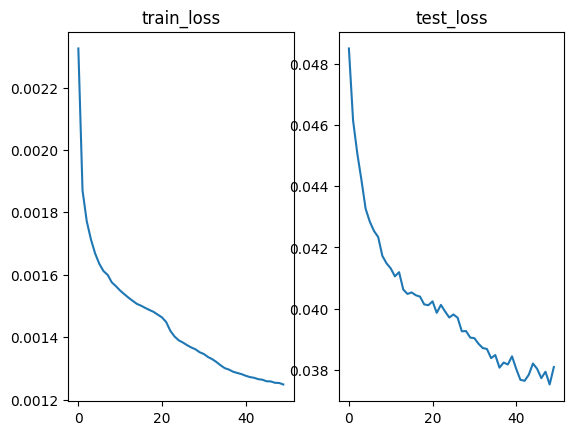

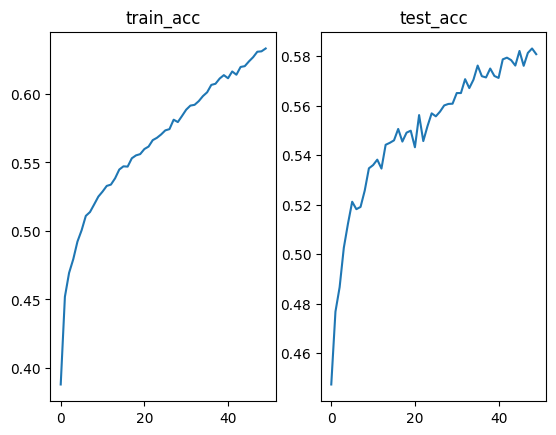

In [40]:
fig1, (ax1,ax2) = plt.subplots(1,2)
fig2, (ax3,ax4) = plt.subplots(1,2)

ax1.plot(hist['train_loss'])
ax3.plot(hist['train_acc'])
ax2.plot(hist['test_loss'])
ax4.plot(hist['test_acc'])

ax1.set_title('train_loss')
ax2.set_title('test_loss')
ax3.set_title('train_acc')
ax4.set_title('test_acc');

<ipython-input-41-fdcfdabe1d4c>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample, device=device).unsqueeze(0)


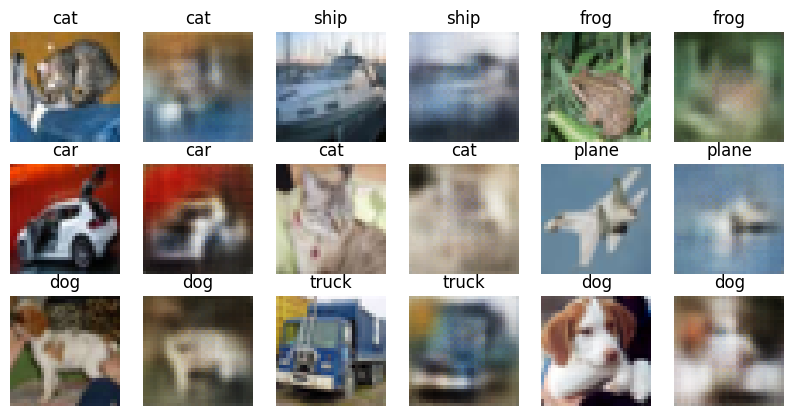

In [41]:
#Visualize Data
def show_batch(image_batch, label_batch):
    net_1.eval()
    net_2.eval()
    net_3.eval()
    plt.figure(figsize=(10,10))
    for n in range(36//2):
        if n%2 == 0:
            ax = plt.subplot(6,6,n+1)
            sample = image_batch[n]
            img = sample / 2 + 0.5     # unnormalize
            img = img.numpy()
            plt.imshow(np.transpose(img, (1, 2, 0)))
            plt.title(CLASS_NAMES[label_batch[n]])
            plt.axis("off")
        else:
            ax = plt.subplot(6,6,n+1)
            sample = torch.tensor(sample, device=device).unsqueeze(0)
            out_1 = net_1(sample)
            img   = net_2(out_1).detach().cpu()
            output_3 = net_3(out_1)
            scores, label = torch.max(output_3, 1)
            img = img.squeeze(0)
            img = img / 2 + 0.5     # unnormalize
            img = img.numpy()
            plt.imshow(np.transpose(img, (1, 2, 0)))
            plt.title(CLASS_NAMES[label.item()])
            plt.axis("off")
sample_images, sample_labels = next(iter(testloader))
show_batch(sample_images, sample_labels)

CONCLUSION:

- The unsupervised learning is not good enought compared with the supervised learning

- The bottleneck representation should compress the full image information

- The classifier doesn't understand the encoded image representation.

Further:

- Try to play with the network topology

- Train an supervised classification model pretrained from the unsupervised stage

# FAILED EXPERIMENTS

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net_1      = EncoderNet().to(device)
net_2      = EncoderNet().to(device)
net_3      = ClassifierNet(net_1.out_size, len(CLASS_NAMES)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(net_1.parameters())
optimizer_2 = optim.Adam(net_2.parameters())
optimizer_3 = optim.Adam(net_3.parameters())

hist = {}
hist['train_loss'] = []
hist['train_acc'] = []
hist['test_loss'] = []
hist['test_acc'] = []

for epoch in range(50):
    net_1.train()
    net_2.train()
    net_3.train()
    train_loss = 0
    nSamples = 0
    train_correct = 0
    for batch_idx, (data, target) in enumerate(trainloader, start=0):
        #Unsupervised Feature Extraction 
        data = data.to(device)
        output_1 = net_1(data)
        output_2 = net_2(data)
        loss = criterion(output_1, output_2)
        train_loss += loss.item()
        nSamples += data.size(0)

        optimizer_1.zero_grad()
        optimizer_2.zero_grad()
        loss.backward()
        optimizer_1.step()
        optimizer_2.step()

        #Supervised Feature classification
        target   = target.to(device)
        output_3 = net_3(output_1.detach())
        loss_3   = criterion(output_3, target)

        optimizer_3.zero_grad()
        loss_3.backward()
        optimizer_3.step()
        
        scores, predictions = torch.max(output_3, 1)
        train_correct += int(sum(predictions == target))

    train_loss     = train_loss/nSamples
    train_accuracy = train_correct / nSamples
    hist['train_loss'].append(train_loss)
    hist['train_acc'].append(train_accuracy)
    print(f"{epoch}: train_Loss: {train_loss:.3}, Accuracy: {train_accuracy:.3}, ", end='')

    net_1.eval()
    net_3.eval()

    test_loss = 0
    nSamples = 0
    test_correct = 0

    example_images = []
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)          
            output_1 = net_1(data)
            output_3 = net_3(output_1)
            test_loss += criterion(output_3, target).item()
            
            scores, predictions = torch.max(output_3, 1)
            nSamples += target.size(0)
            test_correct += int(sum(predictions == target))

    test_accuracy = test_correct / nSamples
    test_loss = test_loss/nSamples

    hist['test_loss'].append(test_loss)
    hist['test_acc'].append(test_accuracy)
    print(f"test_loss: {test_loss:.3}, test_accuracy: {test_accuracy:.3}")

print("Finished Training")